In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random
from collections import defaultdict

class Portfolio():
    def __init__(self,syms,sym_data):
        self.syms = syms
        self.sym_data = sym_data

class QTrader(object):
    def __init__(self, sym_data, eta=1, transaction_cost=0.005, position=10):
        self.sym_data = sym_data
        self.stock_data = sym_data#pd.merge(pd.read_csv('./tbill.csv', index_col='Date'), pd.read_csv('./^GSPC.csv', index_col='Date'), right_index=True, left_index=True).sort_index()
        ret = self.stock_data['Close'].rolling(window=2, center=False).apply(lambda x: x[1] / x[0] - 1)
        # These are price returns and the weekly returns for TBills (3 months)self.stock_data['Close']
        self.returns = pd.DataFrame({
                                        'stocks': self.stock_data['Close'].rolling(window=2, center=False).apply(lambda x: x[1] / x[0] - 1),
                                        'tbills': (ret.std()) ,
                                    }, index=self.stock_data.index)

        self.returns['risk_adjusted'] = (self.returns.stocks - self.returns.tbills)
        self.returns['risk_adjusted_moving'] = self.returns.risk_adjusted.rolling(window=12).apply(lambda x: x.mean())
        self.returns['risk_adjusted_stdev'] = self.returns.risk_adjusted.rolling(window=12).apply(lambda x: x.std())
        self.returns['risk_adjusted_high'] = self.returns.risk_adjusted_moving + 1.5 * self.returns.risk_adjusted_stdev
        self.returns['risk_adjusted_low'] = self.returns.risk_adjusted_moving - 1.5 * self.returns.risk_adjusted_stdev
        self.returns['state'] = (self.returns.risk_adjusted > self.returns.risk_adjusted_high).astype('int') - \
                                (self.returns.risk_adjusted < self.returns.risk_adjusted_high).astype('int') # pd.qcut(self.returns.sharpe_moving, 10, labels=range(10))
    def graph_portfolios(self):

        midpoint = int(len(self.returns.index) / 2)
        training_indexes = self.returns.index[:midpoint] 
        testing_indexes = self.returns.index[midpoint:]

        portfolios = pd.DataFrame({
            'buy_and_hold': self.buy_and_hold(testing_indexes),
            'buy_tbills': self.buy_tbills(testing_indexes),
            'random': self.random(testing_indexes),
            'qtrader': self.q_holdings(training_indexes, testing_indexes)
            }, index=testing_indexes)

        portfolio_values = pd.DataFrame({
                'buy_and_hold': self.evaluate(portfolios.buy_and_hold),
                'buy_tbills': self.evaluate(portfolios.buy_tbills),
                'random': self.evaluate(portfolios.random),
                'qtrader': self.evaluate(portfolios.qtrader)
            }, index=testing_indexes)
        
        portfolio_values.plot()

        plt.annotate("Buy and hold sharpe: {}\n QTrader sharpe: {}".format(self.sharpe(portfolios.buy_and_hold), self.sharpe(portfolios.qtrader)), xy=(0.25, 0.95), xycoords='axes fraction')
        
        plt.show()
        
    def buy_and_hold(self, dates):
        return pd.Series(1, index=dates)

    def buy_tbills(self, dates):
        return pd.Series(0, index=dates)

    # This will go long or short or do nothing randomly
    def random(self, dates):
        return pd.Series(np.random.randint(-1, 2, size=len(dates)), index=dates)

    def calc_returns(self, holdings):
        return pd.Series(self.returns.tbills + holdings * self.returns.risk_adjusted, index=holdings.index)

    def evaluate(self, holdings):
        return (self.calc_returns(holdings) + 1).cumprod()

    def state(self, first_moment, second_moment):
        return first_moment + second_moment * 10

    def q_holdings(self, training_indexes, testing_indexes):
        factors = pd.DataFrame({'action': 0, 'reward': 0, 'state': 0}, index=training_indexes)

        # Initialize Q matrix
        q = {0: {1:0, 0:0, -1:0}}
        
        # For Dyna-Q
        T = np.zeros((3, 3, 3)) + 0.00001
        R = np.zeros((3,3))

        # Episodes
        for i in range(100):
            last_row, last_date = None, None

            for date, row in factors.iterrows():
                return_data = self.returns.loc[date]
                if return_data.state not in q:
                    q[return_data.state] = {1: 0, 0:0, -1:0}

                if last_row is None or np.isnan(return_data.state):
                    state = 0
                    reward = 0
                    action = 0
                else:
                    state = int(return_data.state)
                    if random.random() > 0.001:
                        action = max(q[state], key=q[state].get)
                    else:
                        action = random.randint(-1,1)

                    reward = last_row.action * (return_data.stocks - return_data.tbills)

                    alpha = 1
                    discount = 0.9

                    factors.loc[date, 'reward'] = reward
                    factors.loc[date, 'action'] = action
                    factors.loc[date, 'state'] = return_data.state

                    update = alpha * (factors.loc[date, 'reward'] + discount * max(q[row.state].values()) - q[state][action])
                    if not np.isnan(update):
                        q[state][action] += update

                    # Dyna
                    action_idx = int(last_row.action+1)
                    state_idx = int(last_row.state+1)
                    new_state_idx = int(state+1)

                    T[state_idx][action_idx][new_state_idx] += 1
                    R[state_idx][action_idx] = (1 - alpha) * R[state_idx][action_idx] + alpha * reward

                last_date, last_row = date, factors.loc[date]

            for j in range(100):
                state_idx = random.randint(0,2)
                action_idx = random.randint(0,2)
                new_state = np.random.choice([-1, 0, 1], 1, p=T[state_idx][action_idx]/T[state_idx][action_idx].sum())[0]
                r = R[state_idx][action_idx]
                q[state][action] += alpha * (r + discount * max(q[new_state].values()) - q[state][action])

            sharpe = self.sharpe(factors.action)

            if sharpe > 0.20:
                break
            #print("For episode {} we get an internal sharpe ratio of {}".format(i, self.sharpe(factors.action)))

        testing = pd.DataFrame({'action': 0, 'state': 0}, index=testing_indexes)
        testing['state'] = self.returns.loc[testing_indexes, 'state']
        testing['action'] = testing['state'].apply(lambda state: max(q[state], key=q[state].get))

        print(self.sharpe(testing.action))

        return testing.action

    def discretize(self, number, steps):
        return 0

    def sharpe(self, holdings):
        returns = holdings * (self.returns.stocks - self.returns.tbills)

        return np.nanmean(returns) / np.nanstd(returns)

    


In [2]:
from time import sleep
from binance.client import Client
import pandas as pd
import datetime
import time
import numpy as np
import os
import sys
from statsmodels.tsa.arima_model import ARIMA
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
from statsmodels.tsa.stattools import coint

#from crontab import CronTab
from safe_schedule import SafeScheduler
#add your api keys here
api_key = 'XuozVlFg2WYVemwmHMqCK9j5jSYIV1z3MoDAXY76X2JiCbbgcw7dGxvE0eGVsqhH'
secret_key = 'WyWBCdczLCFvV8fKy16R5dOwhhjK31T7ZrW0cplIzjrvmlSPh5E1KEeAEh5c9I6s'

#Open location of recorded buy/sell walls
bw_location = '/home/me/Documents/BWA/data/watcher/buywalls/'
sw_location = '/home/me/Documents/BWA/data/watcher/sellwalls/'
save_port = '/githome/me/Documents/BWA/data/bw_portfolios'

#Open binance client
client = Client(api_key, secret_key)

#get current time and format to compare with data
current_milli_time = lambda: int(round(time.time() * 1000))


def get_data(sym,prev_k,k,candle_k='5m'):
    """
    Function downloads hist data from binance API with given timestamps
    """
    #previous kline interval
    prev_k = str(prev_k)
    #current kline interval
    k = str(k)
    #download historical data
    data = client.get_historical_klines(sym,interval= candle_k,start_str =int(prev_k),end_str = int(k))
    data = pd.DataFrame(data,columns=['Open time','Open','High','Low','Close','Volume','Close time','Quote volume','Num trades', 'btc buys', 'coin buys', 'ignore'])
    
    # convert from millesecond time to datetime for potential resampling and readability
    data['Open time'] = data['Open time']/1000
    data['Open time'] = data['Open time'].astype('datetime64[s]')
    data = data.set_index('Open time')
    data = data[['Open','High','Low','Close','Close time','Volume']].astype(float)
    return data

def to_dt(v,is_milli=True):
    """
    Function to convert timestamp to datetime object
    has parameter for millisecond uts timestamp
    """
    if(is_milli):
        v = datetime.datetime.fromtimestamp(int(v)/1000)
    else:
        v = datetime.datetime.fromtimestamp(int(v))
    return v

def get_freq_sig(loc):
    """
    Function loads all signal csv files and concatenates them into a signle dataframe
    """
    # cd cmd
    os.chdir(bw_location)
    #sorting by file creation (could use normal sort as filenames are timestamps)
    files = filter(os.path.isfile,os.listdir(bw_location))
    files =  [int(f) for f in files]
    files = list(files)
    #Create frequency signal dataframe
    fs_df = pd.DataFrame(files)
    #sort again
    fs_df = fs_df[0].sort_values()
    #starttime,endtime
    st,end = to_dt(fs_df.iloc[0]),to_dt(fs_df.iloc[-1])
    bw_freq = []
    
    f_len = int(len(os.listdir(loc)))
    for c,i in enumerate(os.listdir(loc)):
        try:
            curr = pd.read_csv(loc+i)
        except Exception as e:
            print(i,e)
 
        curr.columns = ['Coin','Close','Profit','Loss','Date']  
        bw_freq.append(curr)
        if((c/f_len)%10==0):
            pct = str(int((c/f_len)*100))
            print("{}% of files loaded".format(pct))
    bw_freq = pd.concat(bw_freq)
    bw_freq = bw_freq[['Date','Coin','Close']]
    bw_freq.columns = ['Date','Coin','Close']
    bw_freq = bw_freq.sort_values(['Date'],ascending=False)
    #print(all_w.head(), len(all_w))
    #bw_freq['all_freq'] = bw_freq.groupby('Coin')['Coin'].transform('count')
    #bw_freq = bw_freq.sort_values(['Date'],ascending=False)    
    print(st,end)
    print(to_dt(now), now)
    print(fs_df.head())
    return bw_freq

def clean_fs(fs):
    """
    Function to clean frequency signal dataframe
    """
    fs =fs.drop_duplicates()
    fs = fs.sort_values(['Date'],axis=0)
    fs['Date_m'] = fs['Date']
    fs['Date'] = fs['Date']/1000
    fs['Date'] = fs['Date'].astype('datetime64[s]')

    rolling_f = {}
    f_col = []
    """
    for i in fs.iterrows():
        coin = i[1][1]
        if(coin in rolling_f.keys()):
            rolling_f[coin] += 1
            f_col.append(rolling_f[coin])
        else:
            rolling_f[coin] = 1
            f_col.append(rolling_f[coin])
    print(len(fs),len(f_col))
    fs['rolling_freq'] = f_col
    """    
    return fs



def unix_time_millis(dt):
    """
    Function to convert unix time to millesecond
    """
    epoch = datetime.datetime.utcfromtimestamp(0)
    return (dt - epoch).total_seconds() * 1000.0



def interval(intv,st,end):
    """
    Function to resample frequency dataframe to specified frequency
    
    """
    intv_list = []
    out = pd.DataFrame()
    prev = st
    while(prev<end):
        curr = prev+int(86400000*intv)
        n = to_dt(curr).strftime('%Y-%m-%d')
        p = to_dt(prev).strftime('%Y-%m-%d')
        
        print(p,"  |  ",n)
        
        prev = curr
        p = datetime.datetime.strptime(p, '%Y-%m-%d')
        n = datetime.datetime.strptime(n, '%Y-%m-%d')
        intv_list.append(p)
        data = fs_c.loc[p:n]
        #print(data.sort_values('rolling_freq',ascending=False))
        out = pd.concat([out,data],axis=0)
        
    return out.sort_index(),intv_list
    #files.sort(key=lambda x: os.path.getmtime(x))


# Generate portfolios

In [3]:
now = str(current_milli_time())
def intv_port(freq_df,intv):
    dates = freq_df.index.get_level_values('Date').drop_duplicates()

    coins = freq_df.index.get_level_values('Coin')
    date_int = pd.DataFrame({"Date":[d.strftime('%Y-%m-%d') for d in dates]})
    date_int = date_int.drop_duplicates()
    date_int = date_int.astype('datetime64[s]')
    intv_dates = list(date_int.Date[::intv])
    port = pd.DataFrame()
    for c,day in enumerate(intv_dates):
        try:
            st,end = day,intv_dates[c+1]
            print(st,end)
            curr = freq_df.loc[st:end].reset_index()
            curr['Date'] = end

        except Exception as e:
            #print(e)
            break

        curr['all_freq'] = curr.groupby('Coin')['Coin'].transform('count')
        curr = curr[['Date','Coin','Close','all_freq']].sort_values("all_freq",ascending=False)
        curr = curr.sort_values(['Date'],ascending=False)
        curr = curr.set_index('Date')
        port_coins = curr.Coin.drop_duplicates()
        c_group = curr.groupby('Coin')
        curr_port = pd.DataFrame()
        for pc in port_coins:
            curr = c_group.get_group(pc).head(1)
            curr_port = pd.concat([curr_port,curr])
            curr_port = curr_port.sort_values("all_freq",ascending=False).head(9)
        port = pd.concat([port,curr_port])

    port = port.reset_index()
    port['Date'] = port['Date'].astype('datetime64[s]')
    #print(port['Date'])
    d2 = [d.strftime('%Y-%m-%d') for d in port.Date]
    port['Date'] = d2
    port = port.set_index(['Date','Coin'])
    return port

#get freq. signal df
freq_loc = '/home/me/Documents/BWA/data/freq_concat.csv'
fs = pd.read_csv(freq_loc)
#clean freq. signal df
fs_c = clean_fs(fs)
#multilevel indexing for interval tracking
fs_c = fs_c.set_index(['Date','Coin'])
str_intv = input("portfolio interval: ")
intv = int(str_intv)
port = intv_port(fs_c,intv)
port = port.sort_values(['Date','all_freq'],ascending=[True,False])
port.to_csv("/home/me/Documents/BWA/data/{}day_portfolio.csv".format(intv))


portfolio interval: 14
2018-08-24 00:00:00 2018-09-11 00:00:00
2018-09-11 00:00:00 2018-09-25 00:00:00
2018-09-25 00:00:00 2018-10-09 00:00:00
2018-10-09 00:00:00 2018-10-23 00:00:00
2018-10-23 00:00:00 2018-11-06 00:00:00
2018-11-06 00:00:00 2018-11-23 00:00:00
2018-11-23 00:00:00 2018-12-07 00:00:00
2018-12-07 00:00:00 2018-12-21 00:00:00
2018-12-21 00:00:00 2019-01-04 00:00:00
2019-01-04 00:00:00 2019-01-18 00:00:00
2019-01-18 00:00:00 2019-02-01 00:00:00
2019-02-01 00:00:00 2019-02-15 00:00:00
2019-02-15 00:00:00 2019-03-01 00:00:00
2019-03-01 00:00:00 2019-03-18 00:00:00
2019-03-18 00:00:00 2019-04-01 00:00:00


# Analyze portfolio

In [87]:
                    
def backtest(signals,coin):
    # Set the initial capital
    initial_capital= 10.0
    size = initial_capital#/10
    # Create a DataFrame `positions`
    
    positions = pd.DataFrame(index=signals.index).fillna(0.0)
    positions["size"] = size
    positions[coin] = signals[coin]
    
    # Buy a 100 shares
    #calc share amt
    #print("im good")
    #print(positions.head())
    share = positions["size"]/positions[coin]
    #cname = str(coin)+""
    #print("im good")
    positions["share"] = share.values*signals['signal'].values
    
    # Initialize the portfolio with value owned   
    portfolio = positions.multiply(signals[coin], axis=0)
    # Store the difference in shares owned 
    pos_diff = positions.diff()
    # Add `returns` to portfolio
    portfolio['returns'] = portfolio['total'].pct_change()
    portfolio['bt_returns'] = portfolio['returns']*signals['signal']

    # Print the last lines of `portfolio`
    #print(portfolio.astype(str).iloc[-1])
    return portfolio#.astype(str).iloc[-1]

def make_signal(signals):
    #p over 2
    signals["p>2"] = np.where(signals[coin]>signals["2"],1.0,0.0)
    #p over 1
    signals["p>1"] = np.where(signals[coin]>signals["1"],1.0,0.0)
    #p over-1
    signals["p>-1"] = np.where(signals[coin]>signals["-1"],1.0,0.0)
    #p over -2
    signals["p>-2"] = np.where(signals[coin]>signals["-2"],1.0,0.0)
    # -2 stop loss with -5% risk adj
    signals['stop'] = signals["-2"]-(signals["-2"]*.05)
    # -1 stop for 1 crossver
    signals['stop2'] = signals["-1"]
    #shorts below stoploss
    signals['short'] = np.where(signals[coin]<signals["stop"],-1.0,0.0)
    #shorts before stoploss 2
    signals['short2'] = np.where(signals[coin]<signals["stop2"],-1.0,0.0)
    #long above -1
    signals['long'] = signals["p>-2"]-signals["p>-1"]
    #long 2 above 1
    signals['long2'] = signals["p>1"]-signals["p>2"]
    #exit at between 1 and -1
    signals['exit'] = signals["p>-1"]-signals["p>1"]
    #exit at crossover 2 *1%
    signals['exit2'] = signals["p>2"]-(signals["p>2"]+(signals["p>2"]*.01)) #sell 50% take profit 
    #signals['exit'] = np.where(signals[coin]>=signals["exit"],-1.0,0.0)
    signals['positions'] = signals['short']+signals['long']+signals['exit']
    signals['positions2'] = signals['short2']+signals['long2']+signals['exit2']
    
    return signals

def make_signal2(signals):
    #p over 2
    signals["p>2"] = np.where(signals[coin]>signals["2"],1.0,0.0)
    #p over 1
    signals["p>1"] = np.where(signals[coin]>signals["1"],1.0,0.0)
    signals['ss'] = -1
    signals["short"] = np.where(signals[coin]<signals["-1"],-1.0,0.0)
    #p over-1
    #Long zone 1
    signals["positions"] = signals["p>1"]+signals['short']#-signals["p>2"]#np.where(signals[coin]<signals["-1"],1.0,0.0)
    signals["positions"] = np.where(signals["positions"]==signals["ss"],0.0,1.0)
    #signals[[coin,"positions"]].plot()
    #plt.show()
    #p over -2
    #signals["z-1"] = np.where(signals[coin]>signals["-2"],1.0,0.0)
    return signals

def live_trader(portfolio,coin):
        #print(portfolio.head())
        holdings = 0
        p1 = 0
        entry_time = 0
        exit_time = 0
        pnls = []
        trade_ct = 0
        hold_return = portfolio[coin].iloc[-1]/portfolio[coin].iloc[0]
        #print(portfolio.head())
        for t in range(len(portfolio)):
            #print(portfolio['pos_diff'].iloc[t])
            #buy rep
            if portfolio['pos_diff'].iloc[t] == 1:
                holdings = portfolio['max_holdings'].iloc[t]
                #entry_time = portfolio.index.values[t].astype(datetime)
                print("buying... {} shares at: {}".format(holdings,portfolio[coin].iloc[t]))
                p1 = portfolio[coin].iloc[t]
                
            #sell rep    
            elif portfolio['pos_diff'].iloc[t] == -1 and holdings != 0:
                profit = (1-(portfolio[coin].iloc[t]/p1))*100
                #print(profit)
                #exit_time = portfolio.index.values[t].astype(datetime)
                #t_held = datetime.timedelta(entry_time,exit_time)
                print("selling... {} shares at: {} p/l {}".format(holdings,portfolio[coin].iloc[t],profit))
                holdings = 0
                pnls.append(profit)
                trade_ct +=1

            elif t == len(portfolio)-2:
                print("\nAlgo pnl: {}% Holding pnl: {}%".format(sum(pnls),hold_return))
                
           
            
                

Index(['2019-03-18', '2019-04-01'], dtype='object', name='Date')
2019-03-18 00:00:00 2019-04-01 00:00:00


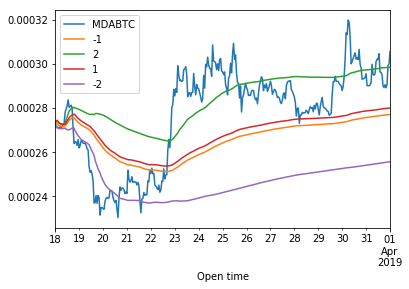

buying... 366.63611365719527 shares at: 0.00027275
selling... 366.63611365719527 shares at: 0.0002705 p/l 0.8249312557286781
buying... 396.79390524561546 shares at: 0.00025202
selling... 396.79390524561546 shares at: 0.00025034 p/l 0.6666137608126288
buying... 395.6165684218856 shares at: 0.00025277
selling... 395.6165684218856 shares at: 0.00025017 p/l 1.0286030778968835
buying... 396.1494275640772 shares at: 0.00025243
selling... 396.1494275640772 shares at: 0.00024789 p/l 1.7985184011409028
buying... 383.4208811011848 shares at: 0.00026081

Algo pnl: 4.318666495579093% Holding pnl: 1.1153705732018986%


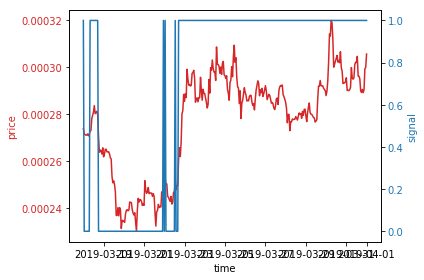

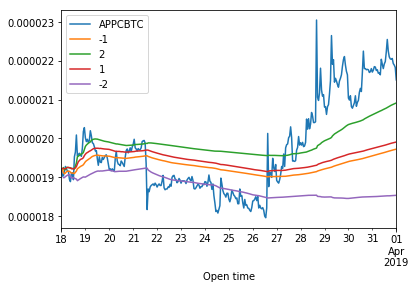

buying... 5219.206680584552 shares at: 1.916e-05
selling... 5219.206680584552 shares at: 1.915e-05 p/l 0.05219206680583399
buying... 5230.125523012553 shares at: 1.912e-05
selling... 5230.125523012553 shares at: 1.894e-05 p/l 0.9414225941422494
buying... 5120.327700972863 shares at: 1.953e-05
selling... 5120.327700972863 shares at: 1.948e-05 p/l 0.2560163850486519
buying... 5112.474437627812 shares at: 1.956e-05
selling... 5112.474437627812 shares at: 1.95e-05 p/l 0.30674846625766694
buying... 5083.884087442807 shares at: 1.967e-05
selling... 5083.884087442807 shares at: 1.942e-05 p/l 1.2709710218607007
buying... 5122.950819672132 shares at: 1.952e-05
selling... 5122.950819672132 shares at: 1.935e-05 p/l 0.8709016393442681
buying... 4967.709885742674 shares at: 2.013e-05
selling... 4967.709885742674 shares at: 1.876e-05 p/l 6.805762543467453
buying... 5227.391531625719 shares at: 1.913e-05
selling... 5227.391531625719 shares at: 1.9e-05 p/l 0.6795608991113422
buying... 5130.83632632119

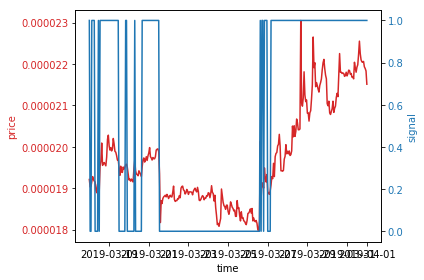

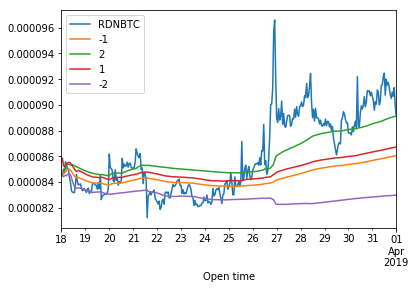

buying... 1176.6090128250382 shares at: 8.499e-05
selling... 1176.6090128250382 shares at: 8.436e-05 p/l 0.7412636780797732
buying... 1182.1728336682822 shares at: 8.459e-05
selling... 1182.1728336682822 shares at: 8.401e-05 p/l 0.6856602435275971
buying... 1191.7530687641522 shares at: 8.391e-05
selling... 1191.7530687641522 shares at: 8.346e-05 p/l 0.5362888809438693
buying... 1182.4524062906469 shares at: 8.457e-05
selling... 1182.4524062906469 shares at: 8.262e-05 p/l 2.3057821922667587
buying... 1160.4966925844262 shares at: 8.617e-05
selling... 1160.4966925844262 shares at: 8.374e-05 p/l 2.8200069629801594
buying... 1190.1928112354203 shares at: 8.402e-05
selling... 1190.1928112354203 shares at: 8.386e-05 p/l 0.19043084979766256
buying... 1179.9410029498526 shares at: 8.475e-05
selling... 1179.9410029498526 shares at: 8.418e-05 p/l 0.6725663716814156
buying... 1189.3434823977166 shares at: 8.408e-05
selling... 1189.3434823977166 shares at: 8.373e-05 p/l 0.4162702188391987
buying.

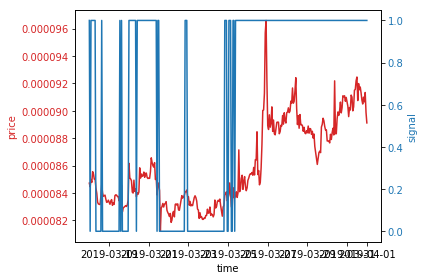

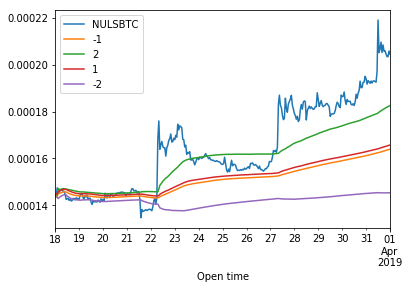

buying... 677.9661016949152 shares at: 0.0001475
selling... 677.9661016949152 shares at: 0.00014463 p/l 1.9457627118644072
buying... 693.0487213251092 shares at: 0.00014429
selling... 693.0487213251092 shares at: 0.0001432 p/l 0.7554231062443573
buying... 693.0967563071805 shares at: 0.00014428
selling... 693.0967563071805 shares at: 0.00014357 p/l 0.49209869697808273
buying... 692.4728204417977 shares at: 0.00014441
selling... 692.4728204417977 shares at: 0.00014269 p/l 1.1910532511598904
buying... 688.752668916592 shares at: 0.00014519
selling... 688.752668916592 shares at: 0.0001432 p/l 1.3706178111440148
buying... 691.5629322268327 shares at: 0.0001446
selling... 691.5629322268327 shares at: 0.00014247 p/l 1.4730290456431372
buying... 698.3240223463687 shares at: 0.0001432

Algo pnl: 7.22798462303389% Holding pnl: 1.4186498300145702%


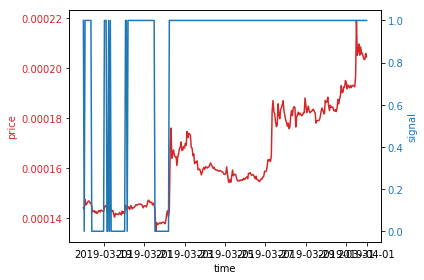

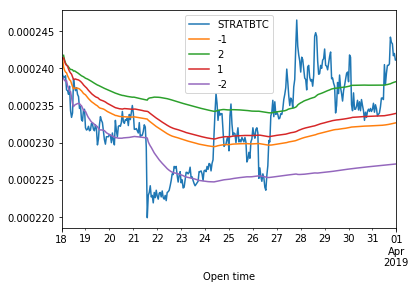

buying... 419.11148365465215 shares at: 0.0002386
selling... 419.11148365465215 shares at: 0.000237 p/l 0.6705783738474524
buying... 421.2299915754002 shares at: 0.0002374
selling... 421.2299915754002 shares at: 0.0002365 p/l 0.3791069924178547
buying... 426.9854824935952 shares at: 0.0002342
selling... 426.9854824935952 shares at: 0.0002328 p/l 0.5977796754910392
buying... 427.71599657827204 shares at: 0.0002338
selling... 427.71599657827204 shares at: 0.0002331 p/l 0.29940119760478723
buying... 427.35042735042737 shares at: 0.000234
selling... 427.35042735042737 shares at: 0.0002318 p/l 0.9401709401709368
buying... 432.7131112072696 shares at: 0.0002311
selling... 432.7131112072696 shares at: 0.0002295 p/l 0.6923409779316381
buying... 435.16100957354223 shares at: 0.0002298
selling... 435.16100957354223 shares at: 0.0002289 p/l 0.3916449086161844
buying... 428.0821917808219 shares at: 0.0002336
selling... 428.0821917808219 shares at: 0.0002274 p/l 2.654109589041098
buying... 434.5936

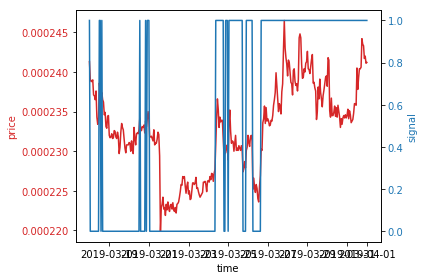

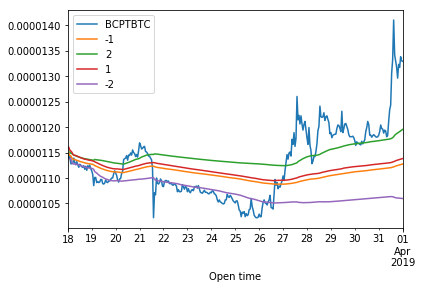

buying... 8779.631255487271 shares at: 1.139e-05
selling... 8779.631255487271 shares at: 1.13e-05 p/l 0.7901668129938422
buying... 8976.660682226213 shares at: 1.114e-05
selling... 8976.660682226213 shares at: 1.11e-05 p/l 0.35906642728904536
buying... 8984.725965858042 shares at: 1.113e-05
selling... 8984.725965858042 shares at: 1.119e-05 p/l -0.5390835579514697
buying... 9115.77028258888 shares at: 1.097e-05
selling... 9115.77028258888 shares at: 1.086e-05 p/l 1.0027347310847867
buying... 9165.902841429881 shares at: 1.091e-05
selling... 9165.902841429881 shares at: 1.079e-05 p/l 1.0999083409715893
buying... 9182.736455463728 shares at: 1.089e-05

Algo pnl: 2.712792754387794% Holding pnl: 1.156657963446475%


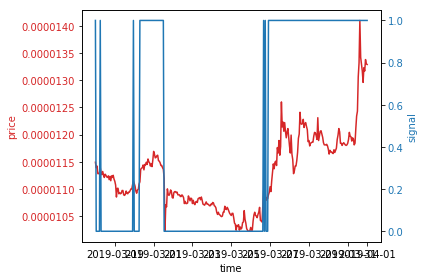

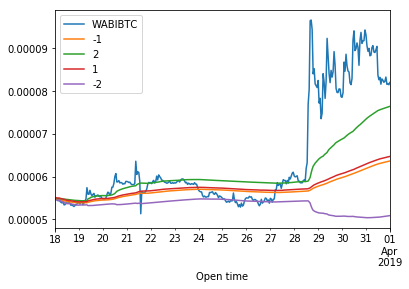

buying... 1826.4840182648402 shares at: 5.475e-05
selling... 1826.4840182648402 shares at: 5.432e-05 p/l 0.785388127853881
buying... 1828.4878405558604 shares at: 5.469e-05
selling... 1828.4878405558604 shares at: 5.418e-05 p/l 0.9325287986834851
buying... 1855.6318426424198 shares at: 5.389e-05
selling... 1855.6318426424198 shares at: 5.357e-05 p/l 0.5938021896455759
buying... 1848.0872297172427 shares at: 5.411e-05
selling... 1848.0872297172427 shares at: 5.34e-05 p/l 1.3121419330992534
buying... 1841.620626151013 shares at: 5.43e-05
selling... 1841.620626151013 shares at: 5.132e-05 p/l 5.488029465930011
buying... 1768.972227136034 shares at: 5.653e-05
selling... 1768.972227136034 shares at: 5.608e-05 p/l 0.796037502211222
buying... 1777.7777777777778 shares at: 5.625e-05
selling... 1777.7777777777778 shares at: 5.683e-05 p/l -1.031111111111116
buying... 1756.8517217146875 shares at: 5.692e-05

Algo pnl: 8.876816906312312% Holding pnl: 1.4948040109389245%


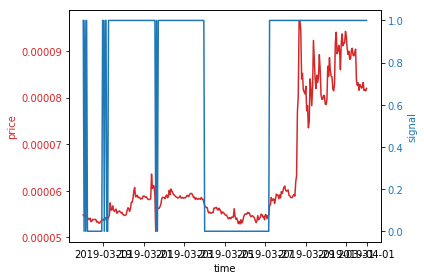

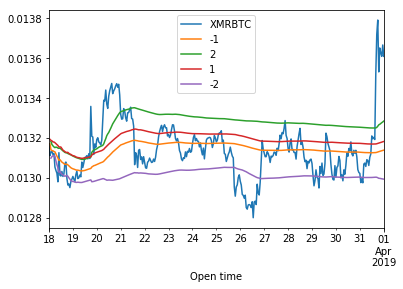

buying... 7.618467164406521 shares at: 0.013126
selling... 7.618467164406521 shares at: 0.013013 p/l 0.8608867895779415
buying... 7.650524060898173 shares at: 0.013071
selling... 7.650524060898173 shares at: 0.012998 p/l 0.5584882564455662
buying... 7.645844483523206 shares at: 0.013079
selling... 7.645844483523206 shares at: 0.013066 p/l 0.09939597828581004
buying... 7.572889057175313 shares at: 0.013205
selling... 7.572889057175313 shares at: 0.013177 p/l 0.2120408936009066
buying... 7.5746099075897595 shares at: 0.013202
selling... 7.5746099075897595 shares at: 0.013155 p/l 0.35600666565671624
buying... 7.590132827324479 shares at: 0.013175
selling... 7.590132827324479 shares at: 0.013138 p/l 0.2808349146109945
buying... 7.5820759724012445 shares at: 0.013189
selling... 7.5820759724012445 shares at: 0.013152 p/l 0.28053681097883754
buying... 7.568876778686043 shares at: 0.013212
selling... 7.568876778686043 shares at: 0.013122 p/l 0.6811989100817373
buying... 7.583225904299689 share

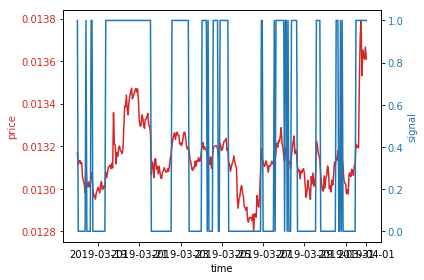

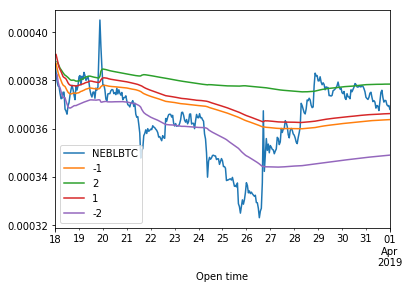

buying... 265.81605528973955 shares at: 0.0003762
selling... 265.81605528973955 shares at: 0.000374 p/l 0.5847953216374213
buying... 264.69031233456855 shares at: 0.0003778
selling... 264.69031233456855 shares at: 0.000376 p/l 0.47644256220223946
buying... 265.3927813163482 shares at: 0.0003768
selling... 265.3927813163482 shares at: 0.000376 p/l 0.2123142250530785
buying... 265.041081367612 shares at: 0.0003773
selling... 265.041081367612 shares at: 0.0003779 p/l -0.15902464882056044
buying... 264.4802962179318 shares at: 0.0003781
selling... 264.4802962179318 shares at: 0.0003761 p/l 0.5289605924358676
buying... 272.18290691344583 shares at: 0.0003674
selling... 272.18290691344583 shares at: 0.0003423 p/l 6.831790963527484
buying... 277.700638711469 shares at: 0.0003601
selling... 277.700638711469 shares at: 0.0003584 p/l 0.47209108580951176
buying... 277.700638711469 shares at: 0.0003601
selling... 277.700638711469 shares at: 0.0003575 p/l 0.7220216606498187
buying... 277.7006387114

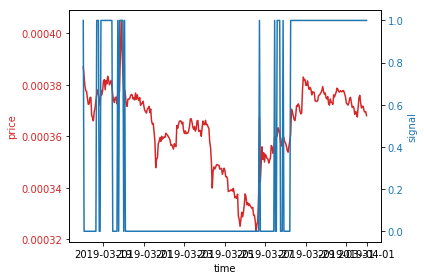

In [88]:
import ffn
p_dates = port.index.get_level_values('Date').drop_duplicates()
returns = []
all_ports = pd.DataFrame()
lastn = p_dates[-2:]
print(lastn)
returns = []
totals = []
coins = []
st_price = []
end_price = []

hist_data = None
for c,d in enumerate(lastn):
    if(c>len(lastn)-1):
        break
    try:
        st = datetime.datetime.strptime(d, '%Y-%m-%d')
        end = datetime.datetime.strptime(lastn[c+1], '%Y-%m-%d')
        print(st,end)
        st,end = int(unix_time_millis(st)),int(unix_time_millis(end))
        prev_st = st-86400000*intv
        curr_port = port.loc[d]
        p_coins = curr_port.index.get_level_values('Coin').values
        curr_port_hist = pd.DataFrame()
        port_hist = pd.DataFrame()
        #for coin in p_coins:
        #    q_hist = get_data(coin,st,end,candle_k='1h')
        #    port_hist[coin] = q_hist.Close
            
        for coin in p_coins:
            #current hist ...lazy way
            #c_hist = get_data(coin,st,end,candle_k='1h')
            #btc_hist = get_data('BTCUSDT',st,end,candle_k='1h')
            #q trader hist with prior data for training
            q_hist = get_data(coin,st,end,candle_k='1h')
            prices = pd.DataFrame()
            st_price.append(q_hist.Close.iloc[0])
            end_price.append(q_hist.Close.iloc[-1])

            high = q_hist.High
            prices[coin] = q_hist['Close']
            
            # Compute the cumulative moving average of the price
            prices['-1'] = [prices[coin][:i].mean() for i in range(len(prices))]
            vol = [prices[coin][:i].std() for i in range(len(prices))]
            ch = [high[:i].mean() for i in range(len(high))]
            prices['2'] = prices['-1'] + vol
            prices['1'] = ch
            prices['-2'] = prices['-1'] -vol
            prices.plot()
            plt.show()
            signals = make_signal2(prices.copy())
            #print(signals.head())
            #print(signals[[coin,'long','short','exit','positions']])
            prices['returns'] = np.log(prices[coin] / prices[coin].shift(1))
            prices['cum_returns'] = prices['returns'].cumsum()
            #signals['positions'] = signals['positions']+signals['positions2']
            prices["signal"] = signals['positions']
            #print(prices["signal"].tail())
            prices["pos_diff"] = prices['signal'].diff()
            prices['bt_returns'] = (prices['returns']*prices["signal"]).cumsum()
            #print(prices[['bt_returns','cum_returns']].iloc[-1])
            portfolio = prices[[coin,'pos_diff','signal']].copy()
            portfolio['max_holdings'] = .1/portfolio[coin]
            live_trader(portfolio,coin)
            #print(prices.head())
            #bt = backtest(prices,coin)
            
            #returns.append(prices['bt_returns'].iloc[-1])
            #totals.append(bt['total'])
            #coins.append(coin)
            
            fig, ax1 = plt.subplots()

            color = 'tab:red'
            ax1.set_xlabel('time')
            ax1.set_ylabel('price', color=color)
            ax1.plot(signals[coin],color=color)
            ax1.tick_params(axis='y', labelcolor=color)

            ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

            color = 'tab:blue'
            ax2.set_ylabel("signal", color=color)  # we already handled the x-label with ax1
            ax2.plot(prices["signal"], color=color)
            ax2.tick_params(axis='y', labelcolor=color)

            fig.tight_layout()  # otherwise the right y-label is slightly clipped
            plt.show()
            #break
            
            
            
        plt.show()
        break
    except Exception as e:
        print(e)
        pass

#all_ports= all_ports.fillna(0)
#all_ports.to_csv(fname+"all_coins.csv")


In [ ]:
print(coins)
print(returns)

In [7]:
bt_returns = pd.DataFrame(returns, columns=['return'])
bt_returns["Coins"] = coins
bt_returns["return"] = bt_returns["return"]
bt_returns['St_price'] = st_price
bt_returns['End_price'] = end_price

bt_returns

,return,Coins,St_price,End_price
0,NaN,NaN,0.000274,0.000305


In [8]:
p_dates[-3:]

Index(['2019-03-01', '2019-03-18', '2019-04-01'], dtype='object', name='Date')

In [9]:
port.iloc[-9:]

Close  all_freq
Date       Coin                       
2019-04-01 MDABTC   0.000300       676
           DCRBTC   0.004817       241
           MTHBTC   0.000005       232
           LSKBTC   0.000381       204
           XZCBTC   0.001805       183
           OAXBTC   0.000040       138
           LOOMBTC  0.000018       137
           LRCBTC   0.000016       133
           ELFBTC   0.000043       133

In [10]:
p_dates = port.index.get_level_values('Date').drop_duplicates()
returns = []
all_ports = pd.DataFrame()
for c,d in enumerate(p_dates[:-3]):
    if(c>len(p_dates)-1):
        break
    try:
        st = datetime.datetime.strptime(d, '%Y-%m-%d')
        end = datetime.datetime.strptime(p_dates[c+1], '%Y-%m-%d')
        print(st,end)
        
        st,end = int(unix_time_millis(st)),int(unix_time_millis(end))
        prev_st = st-86400000*intv
        curr_port = port.loc[d]
        p_coins = curr_port.index.get_level_values('Coin').values
        curr_port_hist = pd.DataFrame()
        for coin in p_coins:
            #current hist ...lazy way
            #c_hist = get_data(coin,st,end,candle_k='1h')
            #btc_hist = get_data('BTCUSDT',st,end,candle_k='1h')
            #q trader hist with prior data for training
            q_hist = get_data(coin,st,end,candle_k='1h')

SyntaxError: unexpected EOF while parsing (<ipython-input-10-74c9bb597cc9>, line 22)